# Solving the Damped Harmonic Oscillator Using a Physics-Informed Neural Network (PINN)



The goal is to solve the damped harmonic oscillator equation using a Physics-Informed Neural Network (PINN) in PyTorch. The equation governing the damped harmonic oscillator is:

$$
\
\frac{d^2x}{dz^2} + 2 \xi \frac{dx}{dz} + x = 0
\
$$

where:
- $x(z)$  is the displacement of the system as a function of time \( z \),
- $\xi$ is the damping ratio (which we will condition the model on in the range
 $\xi$ in [0.1, 0.4].
- $x_0 = 0.7$ is the initial displacement, and
- $v_0 = \frac{dx}{dz}(0) = 1.2$ is the initial velocity.

The solution will be computed over the domain \( z \in [0, 20] \), and the PINN will be used to learn the solution to this equation while being conditioned on the damping ratio $\xi$.

### Steps:
1. **Define the PDE and initial conditions**: The damped harmonic oscillator equation is implemented as a loss function in the PINN.
2. **Build the PINN architecture**: A neural network is created to solve the PDE by learning the displacement $x(z)$ and the velocity $\frac{dx}{dz}$.
3. **Condition the model on damping ratios**: We condition the PINN model to take in a damping ratio $\xi$ between 0.1 and 0.4.
4. **Training the model**: We use Adam or LBFGS optimization to minimize the PDE residual and initial conditions loss.



### Implementation

In [7]:
import random
import numpy as np
import torch

def seed_everything(seed: int):
    """
    Seed all random number generators for reproducibility.
    Args:
        seed (int): The seed value to use for random number generation.
    """
    # Python random module
    random.seed(seed)

    # Numpy random module
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For all GPUs

    torch.backends.cudnn.deterministic = True


seed = 4
seed_everything(seed)


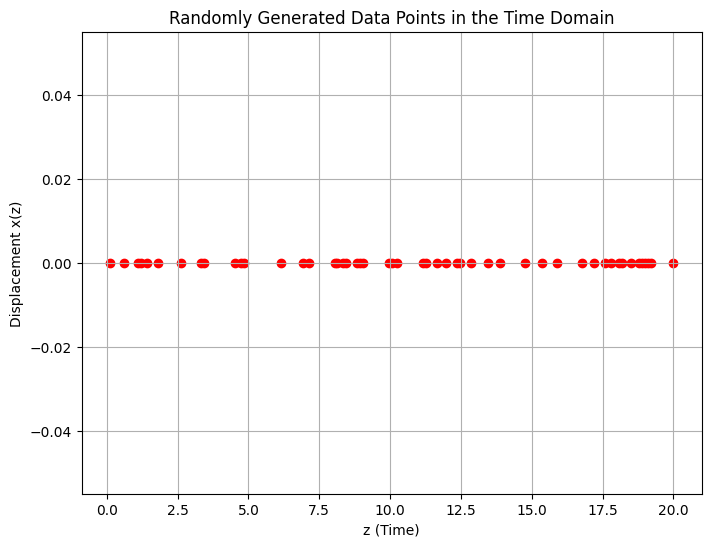

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time domain (z) from 0 to 20
z_points = np.linspace(0, 20, 200)

# Generate random points in the domain for training data
n_points = 50
z_points = np.sort(np.random.choice(z_points, size=n_points, replace=False))

# Visualize the points in the domain
plt.figure(figsize=(8, 6))
plt.scatter(z_points, np.zeros_like(z_points), label='Data points', color='r')
plt.title('Randomly Generated Data Points in the Time Domain')
plt.xlabel('z (Time)')
plt.ylabel('Displacement x(z)')
plt.grid(True)
plt.show()


In [9]:
## Model

import torch
import torch.nn as nn
import math

# Custom Wave Activation Function: Introduced here: https://arxiv.org/pdf/2307.11833
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__()
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x) + self.w2 * torch.cos(x)


# PINNs Model with Adjustable Activation
class PINN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer, activation="tanh", omega_0=30):
        super(PINN, self).__init__()

        # Define activation functions dictionary
        activations = {
            "tanh": nn.Tanh(),
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "elu": nn.ELU(),
            "leaky_relu": nn.LeakyReLU(),
            "gelu": nn.GELU(),
            "silu": nn.SiLU(),  # Swish activation
            "wavelet": WaveAct(),  # Custom Wave Activation
        }

        if activation not in activations:
            raise ValueError(f"Activation '{activation}' not supported. Choose from {list(activations.keys())}.")

        self.activation = activations[activation]

        layers = []
        for i in range(num_layer - 1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))  # Only z as input
                layers.append(self.activation)
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(self.activation)

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

        self.linear = nn.Sequential(*layers)

        # Apply Xavier initialization to all linear layers
        self._init_weights()

    def _init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                # Apply Xavier initialization
                torch.nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)

    def forward(self, z):
        return self.linear(z)




In [10]:
# Optional: Visualize model weights

def visualize_model_weights(model):
    for name, param in model.named_parameters():
        plt.figure(figsize=(10, 6))
        plt.hist(param.detach().cpu().numpy().flatten(), bins=50)
        plt.title(f"Histogram of {name}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()


In [11]:
import torch
import torch.nn as nn

# Define the PDE and initial conditions loss function
class PINNLoss(nn.Module):
    def __init__(self, model, x0=0.7, v0=1.2):
        super(PINNLoss, self).__init__()
        self.model = model
        self.x0 = x0  # Initial displacement
        self.v0 = v0  # Initial velocity

    def forward(self, z, x, xi):
        """
        Loss function for the damped harmonic oscillator PINN.
        z: input time steps (input to the model)
        x: predicted displacement from the PINN model
        """
        # Compute the derivatives
        dx_dz = torch.autograd.grad(x, z, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        d2x_dz2 = torch.autograd.grad(dx_dz, z, grad_outputs=torch.ones_like(dx_dz), create_graph=True)[0]


        # Compute the PDE residual: d²x/dz² + 2ξ dx/dz + x = 0
        pde_residual = d2x_dz2 + 2 * xi * dx_dz + x


        # Compute initial conditions losses

        z0 = torch.tensor([[0.0]]).requires_grad_(True) # z0 = 0
        x0_pred = self.model(z0).requires_grad_(True) # x(0)


        initial_condition = (x0_pred - self.x0)

        initial_velocity_condition = (torch.autograd.grad(x0_pred, z0, grad_outputs=torch.ones_like(x0_pred), create_graph=True)[0] - self.v0)

        # Take means and Combine all losses

        pde_loss = torch.mean(pde_residual**2)
        initial_loss = torch.mean(initial_condition  ** 2)
        velocity_loss = torch.mean(initial_velocity_condition ** 2)

        total_loss = pde_loss + initial_loss + velocity_loss


        return total_loss


In [12]:
print("Number of Sampled Points: ", z_points.shape[0])

Number of Sampled Points:  50


In [13]:
from dataclasses import dataclass
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

In [14]:
@dataclass
class Config:
    learning_rate: float = 1e-3
    epochs: int = 10_000
    hidden_dim: int = 64
    num_layers: int = 6
    activation_function: str = "wavelet"
    xi_range: list = (0.1, 0.4)
    x0: float = 0.7
    v0: float = 1.2
    optimizer: str = "adam"


config = Config()


In [15]:
model = PINN(in_dim=1, hidden_dim=config.hidden_dim, out_dim=1, num_layer=config.num_layers, activation=config.activation_function)


print(model)

PINN(
  (activation): WaveAct()
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): WaveAct()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): WaveAct()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): WaveAct()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): WaveAct()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): WaveAct()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [16]:

# Choose optimizer based on config
if config.optimizer.lower() == "adam":
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
else:
    optimizer = optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')



pinn_loss = PINNLoss(model, x0=config.x0, v0=config.v0)


loss_values = []

def closure():
    global loss_values

    optimizer.zero_grad()  # Zero the gradients
    z = torch.tensor(z_points, dtype=torch.float32, requires_grad=True).unsqueeze(1)  # Add a dimension for the batch
    x = model(z)  # Model output
    xi = torch.tensor(np.random.uniform(*config.xi_range), dtype=torch.float32, requires_grad=True) # damping coefficient range: xi_range = (0.1, 0.4)
    loss = pinn_loss(z, x, xi)  # Compute loss

    # Log the loss for visualization
    loss_values.append(loss.item())
    loss.backward()  # Backpropagate gradients
    return loss

In [17]:

# Store loss values for visualization

best_loss = float("inf")
best_model_state_dict = None  # To store the model's best state

# Training Loop
num_epochs = config.epochs


In [18]:

# CosineAnnealingLR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs, eta_min=1e-6)  # eta_min is the minimum learning rate

# List to store the learning rates during training
learning_rates = []


# Training loop

for epoch in tqdm(range(num_epochs), desc="Training Epochs", unit="epoch"):
    model.train()

    optimizer.step(closure)
    scheduler.step()


    loss = loss_values[-1]
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Track the best model based on loss
    if loss < best_loss:
        best_loss = loss
        best_model_state_dict = model.state_dict()  # Save the model's best state

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss}")




Training Epochs:   0%|          | 16/10000 [00:00<02:03, 80.85epoch/s]

Epoch [0/10000], Loss: 9.653564453125


Training Epochs:   1%|          | 111/10000 [00:01<01:50, 89.87epoch/s]

Epoch [100/10000], Loss: 0.004511060658842325


Training Epochs:   2%|▏         | 211/10000 [00:02<01:48, 90.39epoch/s]

Epoch [200/10000], Loss: 0.0002539553097449243


Training Epochs:   3%|▎         | 311/10000 [00:03<01:47, 90.05epoch/s]

Epoch [300/10000], Loss: 0.00018246538820676506


Training Epochs:   4%|▍         | 411/10000 [00:04<01:46, 90.01epoch/s]

Epoch [400/10000], Loss: 0.00500668678432703


Training Epochs:   5%|▌         | 510/10000 [00:05<01:44, 90.84epoch/s]

Epoch [500/10000], Loss: 0.0038776954170316458


Training Epochs:   6%|▌         | 610/10000 [00:06<01:43, 90.77epoch/s]

Epoch [600/10000], Loss: 0.0007031725253909826


Training Epochs:   7%|▋         | 710/10000 [00:07<01:42, 90.93epoch/s]

Epoch [700/10000], Loss: 0.0015019404236227274


Training Epochs:   8%|▊         | 819/10000 [00:09<01:41, 90.41epoch/s]

Epoch [800/10000], Loss: 0.004630985204130411


Training Epochs:   9%|▉         | 911/10000 [00:10<02:07, 71.54epoch/s]

Epoch [900/10000], Loss: 0.0013046851381659508


Training Epochs:  10%|█         | 1012/10000 [00:11<01:56, 77.43epoch/s]

Epoch [1000/10000], Loss: 0.0031900901813060045


Training Epochs:  11%|█         | 1114/10000 [00:12<01:40, 88.33epoch/s]

Epoch [1100/10000], Loss: 0.004145028535276651


Training Epochs:  12%|█▏        | 1214/10000 [00:13<01:38, 88.93epoch/s]

Epoch [1200/10000], Loss: 0.006665940862149


Training Epochs:  13%|█▎        | 1313/10000 [00:15<01:37, 89.08epoch/s]

Epoch [1300/10000], Loss: 0.008571826852858067


Training Epochs:  14%|█▍        | 1412/10000 [00:16<01:37, 87.87epoch/s]

Epoch [1400/10000], Loss: 0.003975428640842438


Training Epochs:  15%|█▌        | 1514/10000 [00:17<01:35, 89.31epoch/s]

Epoch [1500/10000], Loss: 0.007788985501974821


Training Epochs:  16%|█▌        | 1615/10000 [00:18<01:33, 89.32epoch/s]

Epoch [1600/10000], Loss: 0.0037133602891117334


Training Epochs:  17%|█▋        | 1716/10000 [00:19<01:34, 87.82epoch/s]

Epoch [1700/10000], Loss: 0.011501715518534184


Training Epochs:  18%|█▊        | 1812/10000 [00:20<01:31, 89.16epoch/s]

Epoch [1800/10000], Loss: 0.0016436883015558124


Training Epochs:  19%|█▉        | 1911/10000 [00:21<01:29, 89.97epoch/s]

Epoch [1900/10000], Loss: 0.003912369720637798


Training Epochs:  20%|██        | 2013/10000 [00:23<01:43, 77.00epoch/s]

Epoch [2000/10000], Loss: 0.0003991698322352022


Training Epochs:  21%|██        | 2109/10000 [00:24<01:26, 91.24epoch/s]

Epoch [2100/10000], Loss: 0.002240987028926611


Training Epochs:  22%|██▏       | 2217/10000 [00:25<01:25, 91.26epoch/s]

Epoch [2200/10000], Loss: 0.0045357015915215015


Training Epochs:  23%|██▎       | 2317/10000 [00:26<01:23, 92.42epoch/s]

Epoch [2300/10000], Loss: 0.001057364046573639


Training Epochs:  24%|██▍       | 2417/10000 [00:27<01:22, 92.27epoch/s]

Epoch [2400/10000], Loss: 0.006588144693523645


Training Epochs:  25%|██▌       | 2517/10000 [00:28<01:21, 91.48epoch/s]

Epoch [2500/10000], Loss: 0.003601609729230404


Training Epochs:  26%|██▌       | 2617/10000 [00:29<01:21, 90.65epoch/s]

Epoch [2600/10000], Loss: 0.00792043749243021


Training Epochs:  27%|██▋       | 2717/10000 [00:30<01:20, 90.60epoch/s]

Epoch [2700/10000], Loss: 0.004941502120345831


Training Epochs:  28%|██▊       | 2817/10000 [00:31<01:19, 90.14epoch/s]

Epoch [2800/10000], Loss: 0.0015882820589467883


Training Epochs:  29%|██▉       | 2916/10000 [00:33<01:19, 89.59epoch/s]

Epoch [2900/10000], Loss: 0.002902576234191656


Training Epochs:  30%|███       | 3012/10000 [00:34<01:22, 84.27epoch/s]

Epoch [3000/10000], Loss: 0.0028177881613373756


Training Epochs:  31%|███       | 3116/10000 [00:35<01:19, 86.43epoch/s]

Epoch [3100/10000], Loss: 0.0012994371354579926


Training Epochs:  32%|███▏      | 3211/10000 [00:36<01:16, 88.56epoch/s]

Epoch [3200/10000], Loss: 0.0029410456772893667


Training Epochs:  33%|███▎      | 3317/10000 [00:37<01:14, 90.20epoch/s]

Epoch [3300/10000], Loss: 0.005910762585699558


Training Epochs:  34%|███▍      | 3410/10000 [00:38<01:13, 89.14epoch/s]

Epoch [3400/10000], Loss: 0.0029460936784744263


Training Epochs:  35%|███▌      | 3518/10000 [00:39<01:13, 88.64epoch/s]

Epoch [3500/10000], Loss: 0.005672725848853588


Training Epochs:  36%|███▌      | 3618/10000 [00:41<01:11, 88.90epoch/s]

Epoch [3600/10000], Loss: 0.003829528111964464


Training Epochs:  37%|███▋      | 3711/10000 [00:42<01:11, 88.34epoch/s]

Epoch [3700/10000], Loss: 0.001542285899631679


Training Epochs:  38%|███▊      | 3810/10000 [00:43<01:09, 88.61epoch/s]

Epoch [3800/10000], Loss: 0.001144716516137123


Training Epochs:  39%|███▉      | 3914/10000 [00:44<01:08, 89.16epoch/s]

Epoch [3900/10000], Loss: 0.004491617903113365


Training Epochs:  40%|████      | 4016/10000 [00:45<01:08, 87.78epoch/s]

Epoch [4000/10000], Loss: 0.00025732393260113895


Training Epochs:  41%|████      | 4113/10000 [00:46<01:13, 79.91epoch/s]

Epoch [4100/10000], Loss: 0.0019647679291665554


Training Epochs:  42%|████▏     | 4211/10000 [00:47<01:03, 90.94epoch/s]

Epoch [4200/10000], Loss: 0.0007134819170460105


Training Epochs:  43%|████▎     | 4311/10000 [00:48<01:02, 91.34epoch/s]

Epoch [4300/10000], Loss: 0.0005964082665741444


Training Epochs:  44%|████▍     | 4411/10000 [00:50<01:01, 90.97epoch/s]

Epoch [4400/10000], Loss: 0.001592869171872735


Training Epochs:  45%|████▌     | 4511/10000 [00:51<00:59, 92.20epoch/s]

Epoch [4500/10000], Loss: 0.002996858675032854


Training Epochs:  46%|████▌     | 4611/10000 [00:52<00:58, 91.89epoch/s]

Epoch [4600/10000], Loss: 0.009049606509506702


Training Epochs:  47%|████▋     | 4711/10000 [00:53<00:58, 90.98epoch/s]

Epoch [4700/10000], Loss: 0.002307891147211194


Training Epochs:  48%|████▊     | 4811/10000 [00:54<00:56, 91.33epoch/s]

Epoch [4800/10000], Loss: 0.0004639017570298165


Training Epochs:  49%|████▉     | 4911/10000 [00:55<00:56, 90.27epoch/s]

Epoch [4900/10000], Loss: 0.0031897197477519512


Training Epochs:  50%|█████     | 5011/10000 [00:56<00:54, 91.29epoch/s]

Epoch [5000/10000], Loss: 0.0031294727232307196


Training Epochs:  51%|█████     | 5115/10000 [00:57<01:02, 78.55epoch/s]

Epoch [5100/10000], Loss: 0.0011531185591593385


Training Epochs:  52%|█████▏    | 5214/10000 [00:59<00:53, 89.07epoch/s]

Epoch [5200/10000], Loss: 0.0031938981264829636


Training Epochs:  53%|█████▎    | 5312/10000 [01:00<00:51, 90.33epoch/s]

Epoch [5300/10000], Loss: 0.0002902535779867321


Training Epochs:  54%|█████▍    | 5412/10000 [01:01<00:50, 91.54epoch/s]

Epoch [5400/10000], Loss: 0.004817069508135319


Training Epochs:  55%|█████▌    | 5512/10000 [01:02<00:48, 91.59epoch/s]

Epoch [5500/10000], Loss: 0.0016974401660263538


Training Epochs:  56%|█████▌    | 5612/10000 [01:03<00:47, 91.55epoch/s]

Epoch [5600/10000], Loss: 0.001519446144811809


Training Epochs:  57%|█████▋    | 5712/10000 [01:04<00:47, 91.22epoch/s]

Epoch [5700/10000], Loss: 0.004998624790459871


Training Epochs:  58%|█████▊    | 5812/10000 [01:05<00:46, 90.32epoch/s]

Epoch [5800/10000], Loss: 0.0057626524940133095


Training Epochs:  59%|█████▉    | 5912/10000 [01:06<00:45, 89.39epoch/s]

Epoch [5900/10000], Loss: 0.0002852282195817679


Training Epochs:  60%|██████    | 6012/10000 [01:07<00:44, 90.32epoch/s]

Epoch [6000/10000], Loss: 0.0029216366820037365


Training Epochs:  61%|██████    | 6109/10000 [01:08<00:47, 81.15epoch/s]

Epoch [6100/10000], Loss: 0.0008033749763853848


Training Epochs:  62%|██████▏   | 6211/10000 [01:10<00:44, 85.93epoch/s]

Epoch [6200/10000], Loss: 0.0064099449664354324


Training Epochs:  63%|██████▎   | 6319/10000 [01:11<00:40, 90.61epoch/s]

Epoch [6300/10000], Loss: 0.0026018298231065273


Training Epochs:  64%|██████▍   | 6419/10000 [01:12<00:39, 91.14epoch/s]

Epoch [6400/10000], Loss: 0.0013733272207900882


Training Epochs:  65%|██████▌   | 6519/10000 [01:13<00:37, 91.66epoch/s]

Epoch [6500/10000], Loss: 0.0019052213756367564


Training Epochs:  66%|██████▌   | 6619/10000 [01:14<00:37, 90.69epoch/s]

Epoch [6600/10000], Loss: 0.0049254195764660835


Training Epochs:  67%|██████▋   | 6718/10000 [01:15<00:35, 91.19epoch/s]

Epoch [6700/10000], Loss: 0.006262442097067833


Training Epochs:  68%|██████▊   | 6814/10000 [01:16<00:35, 89.67epoch/s]

Epoch [6800/10000], Loss: 0.004372029099613428


Training Epochs:  69%|██████▉   | 6915/10000 [01:18<00:35, 85.96epoch/s]

Epoch [6900/10000], Loss: 0.0004761262680403888


Training Epochs:  70%|███████   | 7013/10000 [01:19<00:32, 91.20epoch/s]

Epoch [7000/10000], Loss: 0.001885837409645319


Training Epochs:  71%|███████   | 7112/10000 [01:20<00:33, 85.32epoch/s]

Epoch [7100/10000], Loss: 0.003023568307980895


Training Epochs:  72%|███████▏  | 7212/10000 [01:21<00:36, 77.28epoch/s]

Epoch [7200/10000], Loss: 0.00038127132575027645


Training Epochs:  73%|███████▎  | 7316/10000 [01:22<00:30, 89.02epoch/s]

Epoch [7300/10000], Loss: 0.00016129211871884763


Training Epochs:  74%|███████▍  | 7416/10000 [01:23<00:28, 91.36epoch/s]

Epoch [7400/10000], Loss: 0.007030511274933815


Training Epochs:  75%|███████▌  | 7516/10000 [01:24<00:27, 90.77epoch/s]

Epoch [7500/10000], Loss: 0.0005535597447305918


Training Epochs:  76%|███████▌  | 7616/10000 [01:25<00:25, 91.79epoch/s]

Epoch [7600/10000], Loss: 0.0005510829505510628


Training Epochs:  77%|███████▋  | 7716/10000 [01:27<00:24, 91.69epoch/s]

Epoch [7700/10000], Loss: 0.003504417138174176


Training Epochs:  78%|███████▊  | 7816/10000 [01:28<00:23, 91.42epoch/s]

Epoch [7800/10000], Loss: 0.0017629540525376797


Training Epochs:  79%|███████▉  | 7916/10000 [01:29<00:22, 91.13epoch/s]

Epoch [7900/10000], Loss: 8.518843969795853e-05


Training Epochs:  80%|████████  | 8016/10000 [01:30<00:21, 91.19epoch/s]

Epoch [8000/10000], Loss: 0.0015238340711221099


Training Epochs:  81%|████████  | 8116/10000 [01:31<00:20, 90.33epoch/s]

Epoch [8100/10000], Loss: 0.0034468001686036587


Training Epochs:  82%|████████▏ | 8211/10000 [01:32<00:20, 89.28epoch/s]

Epoch [8200/10000], Loss: 0.0017646418418735266


Training Epochs:  83%|████████▎ | 8314/10000 [01:33<00:18, 88.89epoch/s]

Epoch [8300/10000], Loss: 0.002957094693556428


Training Epochs:  84%|████████▍ | 8411/10000 [01:34<00:17, 89.84epoch/s]

Epoch [8400/10000], Loss: 0.0006594252190552652


Training Epochs:  85%|████████▌ | 8510/10000 [01:35<00:16, 90.54epoch/s]

Epoch [8500/10000], Loss: 0.005183505825698376


Training Epochs:  86%|████████▌ | 8619/10000 [01:37<00:15, 90.61epoch/s]

Epoch [8600/10000], Loss: 0.001955334795638919


Training Epochs:  87%|████████▋ | 8719/10000 [01:38<00:14, 90.49epoch/s]

Epoch [8700/10000], Loss: 0.002570787677541375


Training Epochs:  88%|████████▊ | 8819/10000 [01:39<00:12, 90.98epoch/s]

Epoch [8800/10000], Loss: 0.00027196292649023235


Training Epochs:  89%|████████▉ | 8919/10000 [01:40<00:11, 90.34epoch/s]

Epoch [8900/10000], Loss: 0.002560448134317994


Training Epochs:  90%|█████████ | 9009/10000 [01:41<00:10, 90.30epoch/s]

Epoch [9000/10000], Loss: 6.804092845413834e-05


Training Epochs:  91%|█████████ | 9119/10000 [01:42<00:09, 90.52epoch/s]

Epoch [9100/10000], Loss: 0.00024486324400641024


Training Epochs:  92%|█████████▏| 9208/10000 [01:43<00:09, 83.79epoch/s]

Epoch [9200/10000], Loss: 0.008050567470490932


Training Epochs:  93%|█████████▎| 9309/10000 [01:45<00:08, 78.89epoch/s]

Epoch [9300/10000], Loss: 0.0011512420605868101


Training Epochs:  94%|█████████▍| 9416/10000 [01:46<00:06, 89.64epoch/s]

Epoch [9400/10000], Loss: 0.004408635664731264


Training Epochs:  95%|█████████▌| 9516/10000 [01:47<00:05, 90.20epoch/s]

Epoch [9500/10000], Loss: 0.0010427737142890692


Training Epochs:  96%|█████████▌| 9616/10000 [01:48<00:04, 91.24epoch/s]

Epoch [9600/10000], Loss: 2.1501213268493302e-05


Training Epochs:  97%|█████████▋| 9716/10000 [01:49<00:03, 91.06epoch/s]

Epoch [9700/10000], Loss: 0.006684352643787861


Training Epochs:  98%|█████████▊| 9816/10000 [01:50<00:02, 90.77epoch/s]

Epoch [9800/10000], Loss: 0.0009723516413941979


Training Epochs:  99%|█████████▉| 9916/10000 [01:51<00:00, 90.80epoch/s]

Epoch [9900/10000], Loss: 0.0032292213290929794


Training Epochs: 100%|██████████| 10000/10000 [01:52<00:00, 88.78epoch/s]


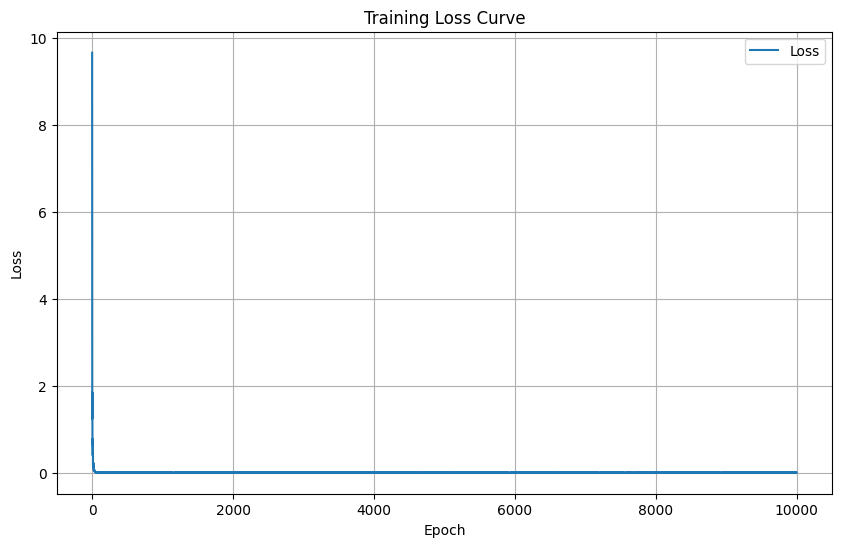

In [19]:

# Plot the loss curve after training
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), loss_values, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()



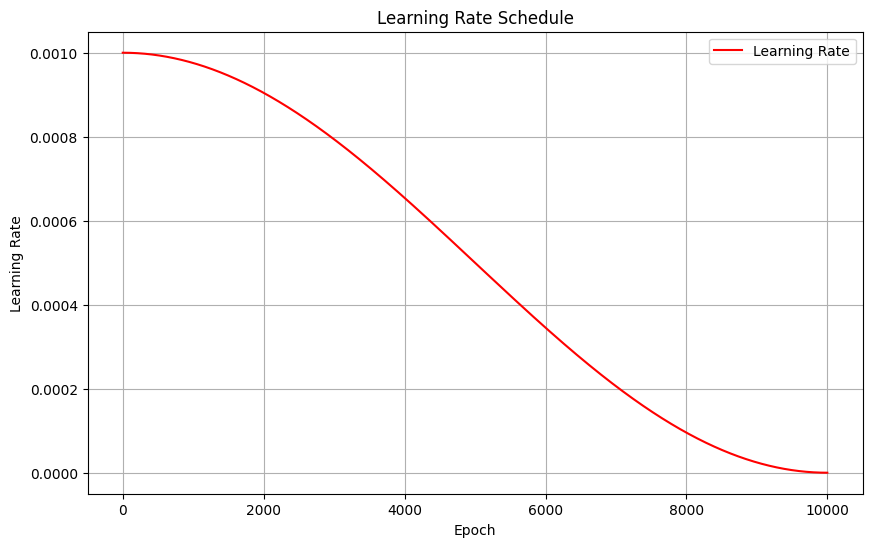

In [20]:
# Plot the learning rate curve after training
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), learning_rates, label="Learning Rate", color='r')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.legend()
plt.show()


In [21]:

# Optional: Visualize model weights after training
# visualize_model_weights(model)

# Save the best model after training
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "best_pinn_model.pth")
    print(f"Best model saved with loss: {best_loss}")


Best model saved with loss: 2.019456405832898e-05


In [23]:

## Model Evaluation and Visualization

model = PINN(in_dim=1, hidden_dim=config.hidden_dim, out_dim=1, num_layer=config.num_layers, activation=config.activation_function)

checkpoint_path = "best_pinn_model.pth"
model.load_state_dict(torch.load(checkpoint_path))  # Load the best model weights from the checkpoint
model.eval()  # Set the model to evaluation mode


z_test = torch.tensor(np.linspace(0, 20, 500), dtype=torch.float32).view(-1, 1)  # Generate 500 points for z in the domain range [0, 20]


with torch.no_grad():
    x_pred = model(z_test)



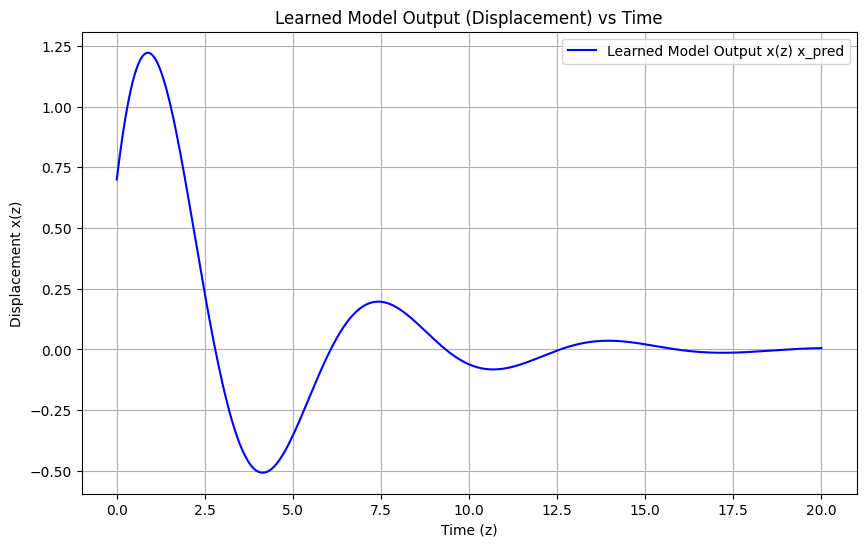

In [24]:
# Plot the learned model output

plt.figure(figsize=(10, 6))
plt.plot(z_test.numpy(), x_pred.numpy(), label="Learned Model Output x(z) x_pred", color='b')
plt.xlabel("Time (z)")
plt.ylabel("Displacement x(z)")
plt.title("Learned Model Output (Displacement) vs Time")
plt.grid(True)
plt.legend()
plt.show()
